<a href="https://colab.research.google.com/github/banshee0716/Financial-Big-Data-Analysis/blob/master/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90%EF%BC%B711_%E5%A4%9A%E6%A8%A1%E6%85%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **設計一個多模態模型，採用(a)早期融合、(b)晚期融合或(c)中期融合的方式進行數據整合（擇一實現）。**

多模態資料來源可包括以下組合之一：
1. 新聞情緒指標 + 股價資料
2. K 線圖 + 股價資料

模型目標可針對分類任務（如股價漲跌預測）或回歸任務（如股價變動幅度預測）。

# **早期融合 多模態整合模型 模型目標針對分類任務（如股價漲跌預測）**

## **新聞情緒資料**

In [7]:
import pandas as pd
news_data = pd.read_csv('RedditNews(train).csv')

news_dict = news_data.groupby('Date')['News'].apply(list).to_dict()
news_dict

{'2008-06-08': ["b'Nim Chimpsky: The tragedy of the chimp who thought he was a boy (and proved that humans were not humane)'",
  'b"Canada: Beware slippery slope\' to censorship, hearing told "',
  'b\'EU Vice-President Luisa Morgantini and the Irish Nobel laureate, Mairead Corrigan, have been tear gased and injured by the IDF while attending the "International Conference on Non-violent Resistance"\'',
  'b"Israeli minister: Israel will attack Iran if it doesn\'t abandon its nuclear program"',
  "b'Albino Killings in Tanzania. At least 19 albinos, including several young children, have been killed in Tanzania in the past year. [video] '",
  'b\'Chiapas: army occupies Zapatista communities in "anti-drug" ops\'',
  "b'Polar bear swims 200 miles, is shot dead upon arrival'",
  "b'News is a contraband item in Pakistan now, and it is being sold on the black market,'",
  "b'Albinos, Long Shunned, Face Threat in Tanzania where witch doctors are now marketing albino skin, bones and hair as ing

In [8]:
# 引入所需的模組
from transformers import AutoTokenizer, AutoModel
import torch

# 設置使用的設備（GPU 或 CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加載 BERT Tokenizer 和 Model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

# 設置為評估模式（不訓練）
bert_model.eval()

# 將模型移動到訓練設備
bert_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [9]:
import torch
import numpy as np
import pandas as pd
from typing import Dict, List

class NewsEmbeddingProcessor:
    def __init__(self, tokenizer, bert_model, device):
        """
        初始化新聞嵌入處理器

        Args:
            tokenizer: BERT tokenizer
            bert_model: BERT 模型
            device: 運算設備 (CPU/GPU)
        """
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.device = device

    def process_daily_news(self, news_dict: Dict[str, List[str]]) -> Dict[str, np.ndarray]:
        """
        處理每日新聞並生成嵌入向量

        Args:
            news_dict: 包含日期和新聞列表的字典

        Returns:
            包含日期和對應嵌入向量的字典
        """
        date_embeddings = {}

        for date, news_list in news_dict.items():
            combined_text = " ".join(news_list)
            embedding = self._generate_embedding(combined_text)
            date_embeddings[date] = embedding

        return date_embeddings

    def _generate_embedding(self, text: str) -> np.ndarray:
        """
        為單一文本生成嵌入向量

        Args:
            text: 要處理的文本

        Returns:
            文本的嵌入向量
        """
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=512
        ).to(self.device)

        with torch.no_grad():
            outputs = self.bert_model(**inputs)

        cls_embedding = (outputs.last_hidden_state[:, 0, :]
                        .squeeze(0)
                        .cpu()
                        .numpy())

        return cls_embedding

    def create_embedding_dataframe(self, date_embeddings: Dict[str, np.ndarray]) -> pd.DataFrame:
        """
        將嵌入向量轉換為DataFrame格式

        Args:
            date_embeddings: 包含日期和嵌入向量的字典

        Returns:
            包含日期和嵌入向量的DataFrame
        """
        df = pd.DataFrame(date_embeddings).T
        df.columns = [f"Embedding_{i}" for i in range(df.shape[1])]
        df['Date'] = pd.to_datetime(df.index, format='%Y-%m-%d')

        return df


# 初始化處理器
processor = NewsEmbeddingProcessor(tokenizer, bert_model, device)

# 處理新聞數據
date_embeddings = processor.process_daily_news(news_dict)

# 轉換為DataFrame
embedding_df = processor.create_embedding_dataframe(date_embeddings)

## **股價資料與指標分析**

In [10]:
# 讀取資料
stock_data = pd.read_csv('DJIA_table(train).csv')  # 包含 Date 和股價指標

stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%d-%m-%Y')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

print(stock_data)

           Date         Open         High          Low        Close  \
0    2015-12-31  17590.66016  17590.66016  17421.16016  17425.02930   
1    2015-12-30  17711.93945  17714.13086  17588.86914  17603.86914   
2    2015-12-29  17547.36914  17750.01953  17547.36914  17720.98047   
3    2015-12-28  17535.66016  17536.90039  17437.33984  17528.26953   
4    2015-12-24  17593.25977  17606.33984  17543.94922  17552.16992   
...         ...          ...          ...          ...          ...   
1858 2008-08-14  11532.07031  11718.28027  11450.88965  11615.92969   
1859 2008-08-13  11632.80957  11633.78027  11453.33984  11532.95996   
1860 2008-08-12  11781.70020  11782.34961  11601.51953  11642.46973   
1861 2008-08-11  11729.66992  11867.11035  11675.53027  11782.34961   
1862 2008-08-08  11432.08984  11759.95996  11388.04004  11734.32031   

         Volume    Adj Close  
0      93690000  17425.02930  
1      59760000  17603.86914  
2      69860000  17720.98047  
3      59770000  17528.

In [11]:
import pandas as pd
import numpy as np
from typing import Tuple

class TechnicalAnalyzer:
    def __init__(self,
                 short_ma: int = 5,
                 long_ma: int = 20,
                 rsi_period: int = 14,
                 macd_fast: int = 12,
                 macd_slow: int = 26,
                 macd_signal: int = 9,
                 bb_period: int = 20,
                 bb_std: int = 2):
        """
        初始化技術分析器

        Args:
            short_ma: 短期均線週期
            long_ma: 長期均線週期
            rsi_period: RSI計算週期
            macd_fast: MACD快線週期
            macd_slow: MACD慢線週期
            macd_signal: MACD信號線週期
            bb_period: 布林通道週期
            bb_std: 布林通道標準差倍數
        """
        self.short_ma = short_ma
        self.long_ma = long_ma
        self.rsi_period = rsi_period
        self.macd_fast = macd_fast
        self.macd_slow = macd_slow
        self.macd_signal = macd_signal
        self.bb_period = bb_period
        self.bb_std = bb_std

    def add_MA(self, df: pd.DataFrame) -> pd.DataFrame:
        """添加移動平均線"""
        df = df.copy()
        df['MA_short'] = df['Close'].rolling(window=self.short_ma).mean()
        df['MA_long'] = df['Close'].rolling(window=self.long_ma).mean()
        return df

    def add_RSI(self, df: pd.DataFrame) -> pd.DataFrame:
        """添加RSI指標"""
        df = df.copy()
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=self.rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=self.rsi_period).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        return df

    def add_MACD(self, df: pd.DataFrame) -> pd.DataFrame:
        """添加MACD指標"""
        df = df.copy()
        exp1 = df['Close'].ewm(span=self.macd_fast).mean()
        exp2 = df['Close'].ewm(span=self.macd_slow).mean()
        df['MACD'] = exp1 - exp2
        df['Signal'] = df['MACD'].ewm(span=self.macd_signal).mean()
        df['MACD_Hist'] = df['MACD'] - df['Signal']
        return df

    def add_Bollinger(self, df: pd.DataFrame) -> pd.DataFrame:
        """添加布林通道指標"""
        df = df.copy()
        df['BB_Middle'] = df['Close'].rolling(window=self.bb_period).mean()
        df['BB_Upper'] = df['BB_Middle'] + df['Close'].rolling(
            window=self.bb_period).std() * self.bb_std
        df['BB_Lower'] = df['BB_Middle'] - df['Close'].rolling(
            window=self.bb_period).std() * self.bb_std
        return df

    def add_Volume_Indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """添加成交量指標"""
        df = df.copy()
        df['Volume_MA'] = df['Volume'].rolling(window=self.short_ma).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']
        return df

    def create_labels(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, dict]:
        """
        根據多個技術指標綜合產生交易信號

        返回:
            df: 添加了交易信號的DataFrame
            stats: 包含信號統計的字典
        """
        df = df.copy()

        # 添加所有技術指標
        df = self.add_MA(df)
        df = self.add_RSI(df)
        df = self.add_MACD(df)
        df = self.add_Bollinger(df)
        df = self.add_Volume_Indicators(df)

        # 綜合多個指標生成交易信號
        conditions = pd.DataFrame()

        # 均線交叉信號
        conditions['MA_Signal'] = (df['MA_short'] > df['MA_long']).astype(int)

        # RSI信號 (超買超賣)
        conditions['RSI_Signal'] = ((df['RSI'] < 30) |
                                  ((df['RSI'] > 30) & (df['RSI'] < 70) &
                                   (df['Close'] > df['MA_short']))).astype(int)

        # MACD信號
        conditions['MACD_Signal'] = (df['MACD'] > df['Signal']).astype(int)

        # 布林通道信號
        conditions['BB_Signal'] = ((df['Close'] < df['BB_Lower']) |
                                 (df['Close'] > df['BB_Middle'])).astype(int)

        # 成交量信號
        conditions['Volume_Signal'] = (df['Volume_Ratio'] > 1).astype(int)

        # 綜合信號 (使用加權平均)
        weights = {
            'MA_Signal': 0.3,
            'RSI_Signal': 0.2,
            'MACD_Signal': 0.2,
            'BB_Signal': 0.2,
            'Volume_Signal': 0.1
        }

        df['Signal_Strength'] = sum(conditions[signal] * weight
                                  for signal, weight in weights.items())

        # 根據信號強度決定最終交易信號
        df['Target'] = (df['Signal_Strength'] >= 0.5).astype(int)

        # 移除包含NaN的行
        df = df.dropna()

        # 統計信號
        stats = {
            '多頭信號數量': sum(df['Target'] == 1),
            '空頭信號數量': sum(df['Target'] == 0),
            '平均信號強度': df['Signal_Strength'].mean(),
            '信號分布': df['Signal_Strength'].describe()
        }

        return df, stats

# 使用示例

# 初始化分析器
analyzer = TechnicalAnalyzer()

# 計算技術指標和交易信號
stock_data, signal_stats = analyzer.create_labels(stock_data)

# 輸出統計信息
print("\n=== 信號統計 ===")
for key, value in signal_stats.items():
    print(f"{key}:")
    print(value)
    print()

# 查看結果
print(stock_data[['Close', 'Signal_Strength', 'Target']].tail())



=== 信號統計 ===
多頭信號數量:
856

空頭信號數量:
988

平均信號強度:
0.4557483731019523

信號分布:
count    1844.000000
mean        0.455748
std         0.295094
min         0.000000
25%         0.200000
50%         0.400000
75%         0.700000
max         1.000000
Name: Signal_Strength, dtype: float64

            Close  Signal_Strength  Target
1858  11615.92969              0.7       1
1859  11532.95996              0.8       1
1860  11642.46973              0.7       1
1861  11782.34961              0.8       1
1862  11734.32031              0.8       1


In [12]:
def combine_stock_and_embeddings(stock_data, embedding_df):
    """
    合併股票數據和新聞embedding數據

    Args:
        stock_data: 股票數據DataFrame
        embedding_df: 新聞embedding DataFrame

    Returns:
        合併後的DataFrame
    """
    # 確保兩個DataFrame都有正確的日期格式
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    embedding_df['Date'] = pd.to_datetime(embedding_df['Date'])

    # 將Date設為索引
    stock_data = stock_data.set_index('Date')
    embedding_df = embedding_df.set_index('Date')

    # 確保日期按照升序排序
    stock_data = stock_data.sort_index()
    embedding_df = embedding_df.sort_index()

    # 合併數據
    combined_df = pd.merge(
        stock_data,
        embedding_df.filter(like='Embedding'),  # 只選擇embedding列
        left_index=True,
        right_index=True,
        how='inner'  # 只保留兩個數據集都有的日期
    )

    print(f"原始股票數據行數: {len(stock_data)}")
    print(f"原始Embedding數據行數: {len(embedding_df)}")
    print(f"合併後數據行數: {len(combined_df)}")
    print(f"合併後特徵數: {len(combined_df.columns)}")

    return combined_df

# 合併數據
combined_data = combine_stock_and_embeddings(stock_data, embedding_df)

原始股票數據行數: 1844
原始Embedding數據行數: 2943
合併後數據行數: 1844
合併後特徵數: 787


## **純股票數據預測**（只有股票的數值）

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class StockPredictor:
    def __init__(self, time_steps=10, test_size=0.2, random_state=42):
        """
        初始化股票預測器

        Args:
            time_steps: 時間序列長度
            test_size: 測試集比例
            random_state: 隨機種子
        """
        self.time_steps = time_steps
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = MinMaxScaler()
        self.model = None

    def prepare_features(self, stock_data: pd.DataFrame) -> tuple:
        """準備特徵資料"""
        # 選擇特徵
        features = [
            'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
            'MA_short', 'MA_long', 'RSI', 'MACD', 'Signal', 'MACD_Hist',
            'BB_Middle', 'BB_Upper', 'BB_Lower', 'Volume_Ratio', 'Signal_Strength'
        ]

        X = stock_data[features].values
        y = stock_data['Target'].values

        # 特徵值正規化
        X_scaled = self.scaler.fit_transform(X)

        # 建立時間序列資料
        X_seq, y_seq = [], []
        for i in range(len(X_scaled) - self.time_steps):
            X_seq.append(X_scaled[i:i + self.time_steps])
            y_seq.append(y[i + self.time_steps])

        return np.array(X_seq), np.array(y_seq), features

    def build_model(self, input_shape: tuple) -> Sequential:
        """建立增強版LSTM模型"""
        model = Sequential([
            # 第一個LSTM層
            LSTM(128, input_shape=input_shape, return_sequences=True),
            BatchNormalization(),
            Dropout(0.3),

            # 第二個LSTM層
            LSTM(64, return_sequences=False),
            BatchNormalization(),
            Dropout(0.3),

            # 全連接層
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),

            Dense(16, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),

            # 輸出層
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def train_and_evaluate(self, stock_data: pd.DataFrame) -> dict:
        """訓練模型並評估結果"""
        # 準備資料
        X_seq, y_seq, features = self.prepare_features(stock_data)

        # 分割資料集
        X_train, X_test, y_train, y_test = train_test_split(
            X_seq, y_seq,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y_seq
        )

        # 建立模型
        self.model = self.build_model((X_train.shape[1], X_train.shape[2]))

        # 設定早停機制
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        # 訓練模型
        history = self.model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )

        # 評估模型
        y_pred = (self.model.predict(X_test) > 0.5).astype(int)

        # 準備結果報告
        results = {
            'test_accuracy': self.model.evaluate(X_test, y_test, verbose=0)[1],
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'history': history.history,
            'feature_names': features
        }

        return results



# 初始化預測器
predictor = StockPredictor(time_steps=10)

# 訓練模型並獲取結果
results = predictor.train_and_evaluate(stock_data)

# 輸出結果
print("\n=== 模型評估結果 ===")
print(f"測試集準確率: {results['test_accuracy']:.2f}")
print("\n分類報告:")
print(results['classification_report'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6105 - loss: 0.7159 - val_accuracy: 0.5986 - val_loss: 0.6831
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6676 - loss: 0.6105 - val_accuracy: 0.5238 - val_loss: 0.6837
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7534 - loss: 0.5471 - val_accuracy: 0.7109 - val_loss: 0.6583
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7768 - loss: 0.5080 - val_accuracy: 0.7415 - val_loss: 0.6200
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8063 - loss: 0.4678 - val_accuracy: 0.6565 - val_loss: 0.6291
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7950 - loss: 0.4637 - val_accuracy: 0.7109 - val_loss: 0.5810
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8450 - loss: 0.3872 - val_accuracy: 0.5918 - val_loss: 0.5852
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8390 - loss: 0.4021 - val_accuracy: 0.7347 - 

##早期融合預測

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5004 - loss: 0.8918 - val_accuracy: 0.4864 - val_loss: 0.7012
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5381 - loss: 0.8070 - val_accuracy: 0.4864 - val_loss: 0.7032
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6110 - loss: 0.7247 - val_accuracy: 0.4864 - val_loss: 0.6952
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6688 - loss: 0.6389 - val_accuracy: 0.6769 - val_loss: 0.6664
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6550 - loss: 0.6282 - val_accuracy: 0.6633 - val_loss: 0.6458
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7376 - loss: 0.5253 - val_accuracy: 0.7347 - val_loss: 0.6032
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7604 - loss: 0.5333 - val_accuracy: 0.6905 - val_loss: 0.5742
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7868 - loss: 0.4797 - val_accuracy: 0.7143 - v

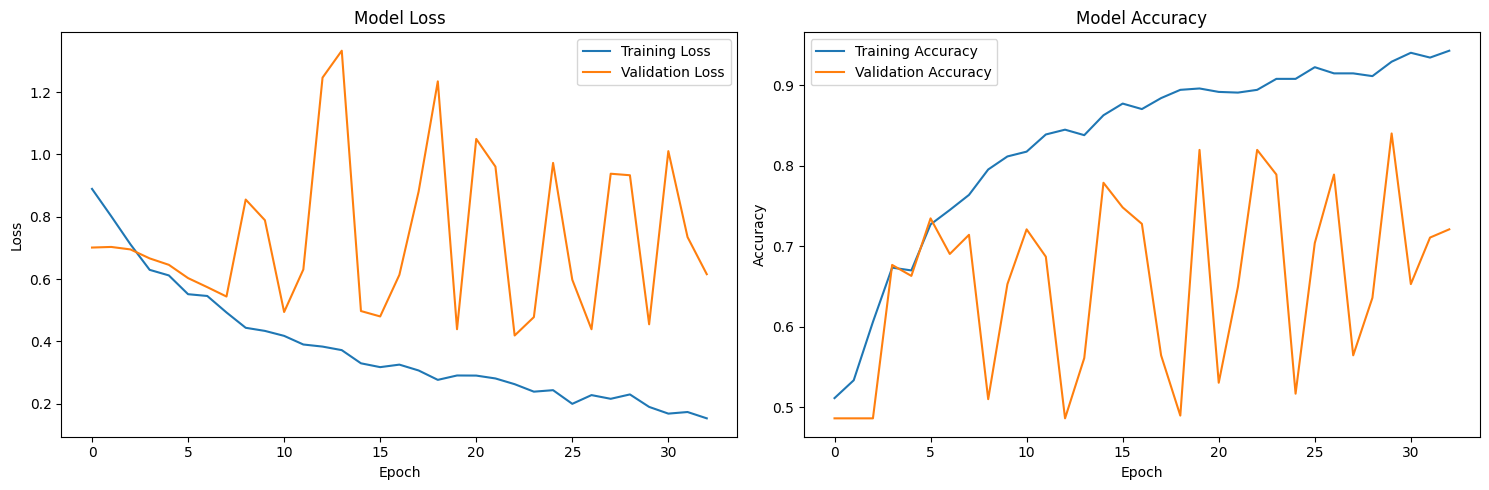

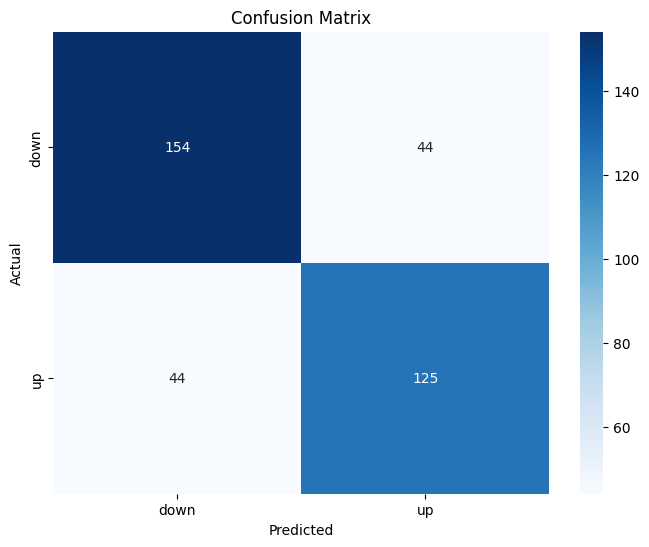

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class EnhancedStockPredictor:
    def __init__(self, time_steps=10, test_size=0.2, random_state=42):
        """
        初始化股票預測器

        Args:
            time_steps: 時間序列長度
            test_size: 測試集比例
            random_state: 隨機種子
        """
        self.time_steps = time_steps
        self.test_size = test_size
        self.random_state = random_state
        self.price_scaler = MinMaxScaler()
        self.news_scaler = MinMaxScaler()
        self.model = None

    def prepare_features(self, combined_data: pd.DataFrame) -> tuple:
        """準備特徵資料"""
        # 分離價格特徵和新聞特徵
        price_features = [
            'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
            'MA_short', 'MA_long', 'RSI', 'MACD', 'Signal', 'MACD_Hist',
            'BB_Middle', 'BB_Upper', 'BB_Lower', 'Volume_Ratio', 'Signal_Strength'
        ]
        news_features = [col for col in combined_data.columns if 'Embedding' in col]

        # 分別正規化價格和新聞特徵
        X_price = self.price_scaler.fit_transform(combined_data[price_features].values)
        X_news = self.news_scaler.fit_transform(combined_data[news_features].values)

        # 合併特徵
        X = np.concatenate([X_price, X_news], axis=1)
        y = combined_data['Target'].values

        # 建立時間序列資料
        X_seq, y_seq = [], []
        for i in range(len(X) - self.time_steps):
            X_seq.append(X[i:i + self.time_steps])
            y_seq.append(y[i + self.time_steps])

        return np.array(X_seq), np.array(y_seq), price_features + news_features

    def build_model(self, input_shape: tuple) -> Sequential:
        """建立增強版LSTM模型"""
        model = Sequential([
            # 第一個LSTM層
            LSTM(256, input_shape=input_shape, return_sequences=True),
            BatchNormalization(),
            Dropout(0.3),

            # 第二個LSTM層
            LSTM(128, return_sequences=True),
            BatchNormalization(),
            Dropout(0.3),

            # 第三個LSTM層
            LSTM(64, return_sequences=False),
            BatchNormalization(),
            Dropout(0.3),

            # 全連接層
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),

            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),

            Dense(16, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),

            # 輸出層
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def train_and_evaluate(self, combined_data: pd.DataFrame) -> dict:
        """訓練模型並評估結果"""
        # 準備資料
        X_seq, y_seq, features = self.prepare_features(combined_data)

        # 分割資料集
        X_train, X_test, y_train, y_test = train_test_split(
            X_seq, y_seq,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y_seq
        )

        # 建立模型
        self.model = self.build_model((X_train.shape[1], X_train.shape[2]))

        # 設定早停機制和學習率調整
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
        ]

        # 訓練模型
        history = self.model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

        # 評估模型
        y_pred = (self.model.predict(X_test) > 0.5).astype(int)

        # 準備結果報告
        results = {
            'test_accuracy': self.model.evaluate(X_test, y_test, verbose=0)[1],
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'history': history.history,
            'feature_names': features
        }

        return results

    def plot_training_history(self, history):
        """繪製訓練歷史"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # 損失函數圖
        ax1.plot(history['loss'], label='Training Loss')
        ax1.plot(history['val_loss'], label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # 準確率圖
        ax2.plot(history['accuracy'], label='Training Accuracy')
        ax2.plot(history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, confusion_mat):
        """繪製混淆矩陣"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            confusion_mat,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['down', 'up'],
            yticklabels=['down', 'up']
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()


# 初始化預測器
predictor = EnhancedStockPredictor(time_steps=10)

# 訓練模型並獲取結果
results = predictor.train_and_evaluate(combined_data)

# 輸出結果
print("\n=== 模型評估結果 ===")
print(f"測試集準確率: {results['test_accuracy']:.4f}")
print("\n分類報告:")
print(results['classification_report'])

    # 繪製訓練歷史
predictor.plot_training_history(results['history'])

    # 繪製混淆矩陣
predictor.plot_confusion_matrix(results['confusion_matrix'])

